In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [3]:
# Define Reber grammar and embedded Reber grammar
default_reber_grammar = [
    [("B",1)],  #(state 0) =B=> (state 1)
    [("T", 2),("P", 3)],  # (state 1) =T=> (state 2) or =P=> (state 3)
    [("X", 5), ("S", 2)], # (state 2) =X=> (state 5) or =S=> (state 2)
    [("T", 3), ("V", 4)], # (state 3) =T=> (state 3) or =V=> (state 4)
    [("V", 6), ("P", 5)], # (state 4) =V=> (state 6) or =P=> (state 5)
    [("X",3), ("S", 6)],  # (state 5) =X=> (state 3) or =S=> (state 6)
    [("E", None)]         # (state 6) =E=> <EOS>
]

embedded_reber_grammar = [
    [("B",1)],  #(state 0) =B=> (state 1)
    [("T", 2),("P", 3)],  # (state 1) =T=> (state 2) or =P=> (state 3)
    [(default_reber_grammar,4)], # (state 2) =REBER=> (state 4)
    [(default_reber_grammar,5)], # (state 3) =REBER=> (state 5)
    [("P", 6)], # (state 4) =P=> (state 6)
    [("T",6)],  # (state 5) =T=> (state 3)
    [("E", None)]         # (state 6) =E=> <EOS>
]


In [4]:
def generate_reber_sequence(grammar):
    state = 0
    sequence = []
    while state is not None:
        transitions = grammar[state]
        symbol, state = transitions[np.random.randint(len(transitions))]
        if isinstance(symbol, list):  # If the symbol is a sub-grammar, generate a sub-sequence
            sequence += generate_reber_sequence(symbol)
        else:
            sequence.append(symbol)
    return ''.join(sequence)

def generate_dataset(grammar, n_samples):
    return [generate_reber_sequence(grammar) for _ in range(n_samples)]

# Generate dataset using embedded Reber grammar
n_samples = 10000
sequences = generate_dataset(embedded_reber_grammar, n_samples)


In [5]:
# Preprocess the data
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
sequences = tokenizer.texts_to_sequences(sequences)
max_sequence_length = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Prepare input and output
X = sequences[:, :-1]  # Input sequences (all but last character)
y = sequences[:, 1:]   # Target sequences (all but first character)
y = to_categorical(y, num_classes=len(tokenizer.word_index) + 1)  # One-hot encode the target

# Verify shapes
print(f"X shape: {X.shape}")  # Should be (n_samples, max_sequence_length-1)
print(f"y shape: {y.shape}")  # Should be (n_samples, max_sequence_length-1, vocab_size)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


X shape: (10000, 44)
y shape: (10000, 44, 8)


In [6]:
# Define the model
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_dim = 128  # Size of the embedding vectors

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length-1))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model.add(TimeDistributed(Dense(units=vocab_size, activation='softmax')))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the model
model.summary()


c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
# verbose level 2 displays more info while training
H = model.fit(X_train, y_train, epochs=100, verbose=2, validation_data=(X_val, y_val))


Epoch 1/100
250/250 - 16s - 66ms/step - accuracy: 0.8666 - loss: 0.3235 - val_accuracy: 0.9099 - val_loss: 0.1341
Epoch 2/100
250/250 - 11s - 44ms/step - accuracy: 0.9165 - loss: 0.1281 - val_accuracy: 0.9210 - val_loss: 0.1127
Epoch 3/100
250/250 - 11s - 43ms/step - accuracy: 0.9206 - loss: 0.1153 - val_accuracy: 0.9207 - val_loss: 0.1115
Epoch 4/100
250/250 - 11s - 42ms/step - accuracy: 0.9208 - loss: 0.1132 - val_accuracy: 0.9208 - val_loss: 0.1110
Epoch 5/100
250/250 - 11s - 43ms/step - accuracy: 0.9206 - loss: 0.1123 - val_accuracy: 0.9202 - val_loss: 0.1111
Epoch 6/100
250/250 - 11s - 43ms/step - accuracy: 0.9206 - loss: 0.1119 - val_accuracy: 0.9206 - val_loss: 0.1110
Epoch 7/100
250/250 - 10s - 41ms/step - accuracy: 0.9205 - loss: 0.1116 - val_accuracy: 0.9213 - val_loss: 0.1107
Epoch 8/100
250/250 - 11s - 42ms/step - accuracy: 0.9203 - loss: 0.1115 - val_accuracy: 0.9209 - val_loss: 0.1105
Epoch 9/100
250/250 - 11s - 44ms/step - accuracy: 0.9206 - loss: 0.1113 - val_accuracy: 

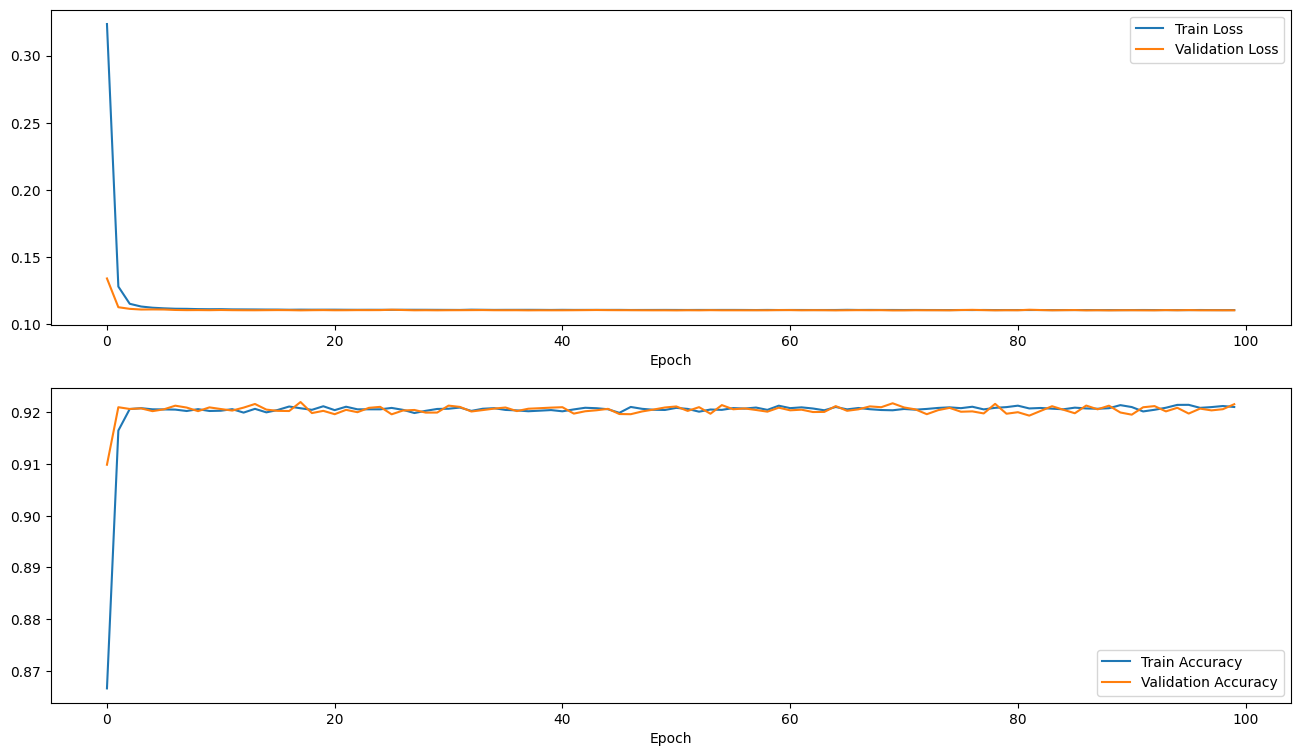

In [8]:
# Function to plot training results
def plot_results(H):
    results = pd.DataFrame({"Train Loss": H.history['loss'], "Validation Loss": H.history['val_loss'],
                            "Train Accuracy": H.history['accuracy'], "Validation Accuracy": H.history['val_accuracy']})
    fig, ax = plt.subplots(nrows=2, figsize=(16, 9))
    results[["Train Loss", "Validation Loss"]].plot(ax=ax[0])
    results[["Train Accuracy", "Validation Accuracy"]].plot(ax=ax[1])
    ax[0].set_xlabel("Epoch")
    ax[1].set_xlabel("Epoch")
    plt.show()

# Plot the results
plot_results(H)


In [9]:
# Function to generate sequences starting with a seed character
def generate_sequence_with_seed(model, tokenizer, seed_text, max_sequence_length, num_chars_to_generate):
    # Tokenize the seed text
    seed_sequence = tokenizer.texts_to_sequences([seed_text])[0]
    generated_sequence = seed_sequence
    
    # Generate characters one by one
    for _ in range(num_chars_to_generate):
        # Pad the current sequence
        padded_sequence = pad_sequences([generated_sequence], maxlen=max_sequence_length-1, padding='post')
        
        # Predict the next character
        predictions = model.predict(padded_sequence)
        predicted_char_index = np.argmax(predictions[0][-1])
        
        # Add the predicted character to the sequence
        generated_sequence.append(predicted_char_index)
    
    # Convert the sequence of indices back to characters
    predicted_sequence = ''.join([tokenizer.index_word.get(index, '') for index in generated_sequence])
    
    return predicted_sequence

# Example usage
seed_text = "B"  # Starting with a valid seed character
num_chars_to_generate = 20  # Number of characters to generate
predicted_sequence = generate_sequence_with_seed(model, tokenizer, seed_text, max_sequence_length, num_chars_to_generate)

print("Generated sequence: ", predicted_sequence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Generated sequence:  b
